In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import torch
import re
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder


# Torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Read in json file
jsonObjTrain = pd.read_json(path_or_buf=r'new_train_df.jsonl', lines=True)
jsonObjTest = pd.read_json(path_or_buf=r'test.jsonl', lines=True)
jsonObjVal = pd.read_json(path_or_buf=r'dev.jsonl', lines=True)

# Select relevant columns
train_df = jsonObjTrain[['string', 'label']]
print("train_df\nRows: ", train_df.shape[0], "\n", train_df.head())
test_df = jsonObjTest[['string', 'label']]
print("\ntest_df\nRows: ", test_df.shape[0], "\n", test_df.head())
val_df = jsonObjVal[['string', 'label']]
print("\nval_df\nRows: ", val_df.shape[0], "\n", val_df.head())

train_df
Rows:  16352 
                                               string       label
0  However, how frataxin interacts with the Fe-S ...  background
1  In the study by Hickey et al. (2012), spikes w...  background
2  The drug also reduces catecholamine secretion,...  background
3  By clustering with lowly aggressive close kin ...  background
4  Ophthalmic symptoms are rare manifestations of...  background

test_df
Rows:  1861 
                                               string       label
0  Chapel, as well as X10 [2], UPC [3] , CoArray ...  background
1  In addition, the result of the present study s...      result
2  Several instruments that more specifically add...  background
3  Organotypic hippocampal slice cultures\nInterf...      method
4  Activated PBMC are the basis of the standard P...  background

val_df
Rows:  916 
                                               string       label
0  These results are in contrast with the finding...      result
1  …nest burrows in cl

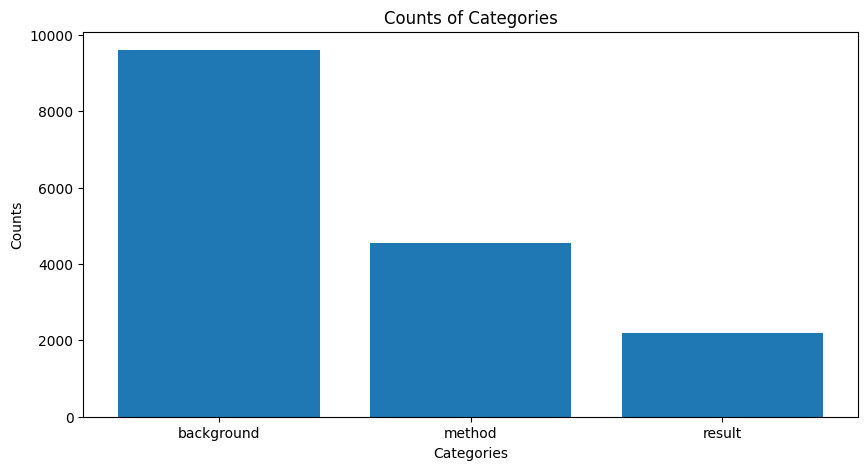

Max number of words:  510
Max chars:  3327


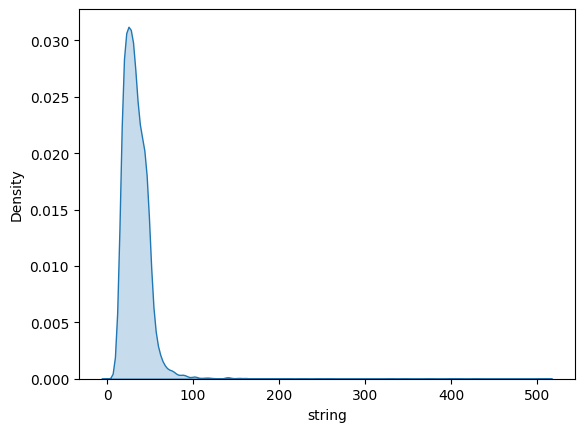

In [ ]:
# Quick EDA
categories = train_df['label'].values.reshape(-1)
counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_counts = counter_categories.values()

# Graph
plt.figure(figsize=(10, 5))
plt.bar(category_names, category_counts)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Counts of Categories')
plt.show()

# Check longest number of words
longest_string = 0
for string in train_df['string']:
    longest_string = max(longest_string, len(string.split()))
print("Max number of words: ", longest_string)

# Check longest number of characters
max_chars = 0
for string in train_df['string']:
    max_chars = max(max_chars, len(string))
print("Max chars: ", max_chars)

# Check for distribution of number of words
plot = sns.kdeplot(train_df['string'].apply(lambda x: len(x.split())), fill=True)

In [ ]:
## Roberta
max_length = 100

# Tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
X_train = train_df['string'].values
X_train_encoded = tokenizer.batch_encode_plus(X_train.tolist(),
                                              pad_to_max_length=True,
                                              max_length=max_length,
                                              return_tensors='pt',
                                              truncation=True)
X_test = test_df['string'].values
X_test_encoded = tokenizer.batch_encode_plus(X_test.tolist(),
                                              pad_to_max_length=True,
                                              max_length=max_length,
                                              return_tensors='pt',
                                              truncation=True)
X_val = val_df['string'].values
X_val_encoded = tokenizer.batch_encode_plus(X_val.tolist(),
                                              pad_to_max_length=True,
                                              max_length=max_length,
                                              return_tensors='pt',
                                              truncation=True)

# Label Encoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'].values)
y_train = torch.tensor(y_train)
# print(y_train.unique())
y_test = label_encoder.transform(test_df['label'].values)
y_test = torch.tensor(y_test)
y_val = label_encoder.transform(val_df['label'].values)
y_val = torch.tensor(y_val)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Create dataset
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train_encoded['input_ids'], X_train_encoded['attention_mask'], y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               sampler=torch.utils.data.RandomSampler(train_dataset),
                                               batch_size=batch_size)
test_dataset = torch.utils.data.TensorDataset(X_test_encoded['input_ids'], X_test_encoded['attention_mask'], y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              sampler=torch.utils.data.SequentialSampler(test_dataset),
                                              batch_size=batch_size)
val_dataset = torch.utils.data.TensorDataset(X_val_encoded['input_ids'], X_val_encoded['attention_mask'], y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                              sampler=torch.utils.data.SequentialSampler(val_dataset),
                                              batch_size=batch_size)

In [ ]:
# Model
model = RobertaForSequenceClassification.from_pretrained('roberta-base',
                                                         num_labels = len(label_encoder.classes_),
                                                         output_attentions = False,
                                                         output_hidden_states = False)
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        batch[2] = batch[2].type(torch.LongTensor)   # casting to long
        labels = batch[2].to(device)

        inputs = {'input_ids':      input_ids,
                  'attention_mask': attention_mask,
                  'labels':         labels,
                 }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return loss_val_avg, predictions, true_vals

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, betas=(0.9, 0.98), eps=1e-6)

epochs = 10
total_steps = len(train_dataloader)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

torch.cuda.empty_cache()
early_stopper = EarlyStopper(patience=3, min_delta=10)
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=True, disable=False, position=0)
    for batch in progress_bar:

        model.zero_grad()

        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        batch[2] = batch[2].type(torch.LongTensor)   # casting to long
        labels = batch[2].to(device)

        inputs = {'input_ids':      input_ids,
                  'attention_mask': attention_mask,
                  'labels':         labels,
                 }

        outputs = model(**inputs)
        loss = outputs.loss
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(train_dataloader)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(val_dataloader)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')

    test_loss, predictions, true_vals = evaluate(test_dataloader)
    test_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Test loss: {test_acc}')
    tqdm.write(f'Accuracy: {test_acc}')

    if early_stopper.early_stop(val_loss):
        print("Early stopped.")
        break

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/511 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.4365107513628827
Validation loss: 0.4370010644197464
Accuracy: 0.8537117903930131
Test loss: 0.8538420204191295
Accuracy: 0.8538420204191295


Epoch 2:   0%|          | 0/511 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.2712048559090571
Validation loss: 0.5053831960620552
Accuracy: 0.8351528384279476
Test loss: 0.8420204191295003
Accuracy: 0.8420204191295003


Epoch 3:   0%|          | 0/511 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.17355996285111383
Validation loss: 0.6491428174335381
Accuracy: 0.8395196506550219
Test loss: 0.8527673293927995
Accuracy: 0.8527673293927995


Epoch 4:   0%|          | 0/511 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.11602139452822259
Validation loss: 0.7211453770769054
Accuracy: 0.8362445414847162
Test loss: 0.8350349274583557
Accuracy: 0.8350349274583557


Epoch 5:   0%|          | 0/511 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.08211039600416803
Validation loss: 0.9483497389431658
Accuracy: 0.8406113537117904
Test loss: 0.845781837721655
Accuracy: 0.845781837721655


Epoch 6:   0%|          | 0/511 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.06258960205008168
Validation loss: 0.9938400053772433
Accuracy: 0.8395196506550219
Test loss: 0.8506179473401397
Accuracy: 0.8506179473401397


Epoch 7:   0%|          | 0/511 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.041826445258376525
Validation loss: 1.1276700722760167
Accuracy: 0.8438864628820961
Test loss: 0.8511552928533047
Accuracy: 0.8511552928533047


Epoch 8:   0%|          | 0/511 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.02704440880601407
Validation loss: 1.2445944897059737
Accuracy: 0.851528384279476
Test loss: 0.846856528747985
Accuracy: 0.846856528747985


Epoch 9:   0%|          | 0/511 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.018254517911883927
Validation loss: 1.3570293229201744
Accuracy: 0.8449781659388647
Test loss: 0.8409457281031704
Accuracy: 0.8409457281031704


Epoch 10:   0%|          | 0/511 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.01309182709141482
Validation loss: 1.357660274053442
Accuracy: 0.8504366812227074
Test loss: 0.8420204191295003
Accuracy: 0.8420204191295003


In [ ]:
test_loss, predictions, true_vals = evaluate(test_dataloader)
val_acc = accuracy(predictions, true_vals)
print(f"Validation Accuracy: {val_acc}")

print(f"Classification Report for EQT types RoBERTa model")
print(classification_report(true_vals, np.argmax(predictions,axis=1), zero_division=0))

Validation Accuracy: 0.8420204191295003
Classification Report for EQT types RoBERTa model
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       997
           1       0.86      0.81      0.83       605
           2       0.70      0.88      0.78       259

    accuracy                           0.84      1861
   macro avg       0.81      0.85      0.83      1861
weighted avg       0.85      0.84      0.84      1861



In [ ]:
By